### Alternative domain for strengthening PAR-2 dimerisation (6HNL)

In [1]:
import os

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter

from src import (
    fold,
    interp_1d_array,
    load_image,
    nb_setup,
    raw_data_path,
    rotated_embryo,
)

%matplotlib inline

nb_setup()

os.makedirs("Figs", exist_ok=True)

In [2]:
if raw_data_path:
    path_wt = raw_data_path + "Imaging/par2_nebd/210722_lp637_tom4,15,60/01"
    path_gcn4 = raw_data_path + "Imaging/par2_nebd/210722_nwg376_tom4,15,60/04"
    path_6hnl = raw_data_path + "Imaging/par2_nebd/220307_nwg481/00"

### Zoomed images: internal membranes

10316.966372919816
10938.02885222996


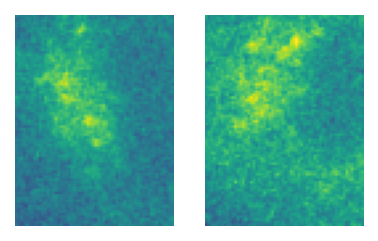

In [3]:
ybox_a = [70, 130]
xbox_a = [60, 140]


def panel_internal(path, ax):
    img = load_image(path + "/af_corrected.tif")
    roi = np.loadtxt(path + "/ROI_fit.txt")
    rotated = rotated_embryo(img, roi, 250, 180, 3)
    rotated_filter = gaussian_filter(rotated, 0.5)
    rotated_box = rotated_filter[xbox_a[0] : xbox_a[1], ybox_a[0] : ybox_a[1]]
    print(np.percentile(rotated_box, 99.9))
    ax.imshow(rotated_box, cmap="viridis", vmin=0, vmax=11418.24050720752)
    ax.axis("off")


if raw_data_path:
    fig, ax = plt.subplots(1, 2)
    panel_internal(path_gcn4, ax[0])
    panel_internal(path_6hnl, ax[1])
    fig.set_size_inches(3, 2)
    fig.savefig("Figs/imgs_endosomes_zoom.png", dpi=600, transparent=True)
    fig.savefig("Figs/imgs_endosomes_zoom.pdf", transparent=True)

### Zoomed images: anterior membrane

6676.549803695137
7187.590638381228


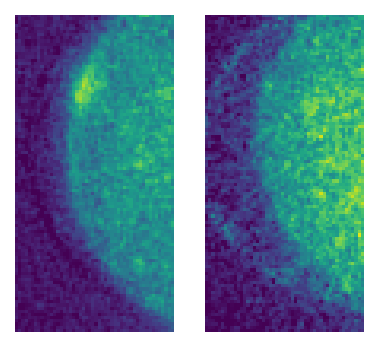

In [4]:
ybox_b = [10, 60]
xbox_b = [50, 150]


def panel_anterior(path, ax):
    img = load_image(path + "/af_corrected.tif")
    roi = np.loadtxt(path + "/ROI_fit.txt")
    rotated = rotated_embryo(img, roi, 250, 180, 3)
    rotated_filter = gaussian_filter(rotated, 0.5)
    rotated_box = rotated_filter[xbox_b[0] : xbox_b[1], ybox_b[0] : ybox_b[1]]
    print(np.percentile(rotated_box, 99.9))
    ax.imshow(rotated_box, cmap="viridis", vmin=0, vmax=8008.113775851759)
    ax.axis("off")


if raw_data_path:
    fig, ax = plt.subplots(1, 2)
    panel_anterior(path_gcn4, ax[0])
    panel_anterior(path_6hnl, ax[1])
    fig.set_size_inches(3, 3)
    fig.savefig("Figs/imgs_anterior_zoom.png", dpi=600, transparent=True)
    fig.savefig("Figs/imgs_anterior_zoom.pdf", transparent=True)

### Images with boxes

12929.27395081726
23378.10027523993


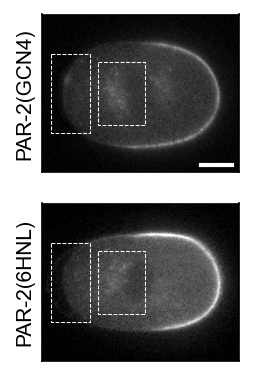

In [5]:
def panel_whole(path, ax, scale_bar=False):
    img = load_image(path + "/af_corrected.tif")
    roi = np.loadtxt(path + "/ROI_fit.txt")
    rotated = rotated_embryo(img, roi, 250, 200, 3)
    print(np.percentile(rotated, 99.9))
    ax.imshow(rotated, cmap="gray", vmin=0, vmax=23327.254397727273)
    ax.set_xticks([])
    ax.set_yticks([])

    # Endosome box
    recta = patches.Rectangle(
        (ybox_a[0], xbox_a[0]),
        ybox_a[1] - ybox_a[0],
        xbox_a[1] - xbox_a[0],
        linewidth=0.5,
        edgecolor="w",
        facecolor="none",
        linestyle="--",
    )
    ax.add_patch(recta)

    # Anterior membrane box
    rectb = patches.Rectangle(
        (ybox_b[0], xbox_b[0]),
        ybox_b[1] - ybox_b[0],
        xbox_b[1] - xbox_b[0],
        linewidth=0.5,
        edgecolor="w",
        facecolor="none",
        linestyle="--",
    )
    ax.add_patch(rectb)

    if scale_bar:
        px = 0.255  # pixel size
        bar_length = 10  # microns
        bar_pixels = bar_length / px
        y = rotated.shape[0] - 10
        ax.plot(
            [rotated.shape[1] - 10 - bar_pixels, rotated.shape[1] - 10],
            [y, y],
            color="w",
            linewidth=2,
        )


if raw_data_path:
    fig, ax = plt.subplots(2, 1)
    panel_whole(path_gcn4, ax[0], scale_bar=True)
    panel_whole(path_6hnl, ax[1])
    ax[0].set_ylabel("PAR-2(GCN4)", fontsize=10)
    ax[1].set_ylabel("PAR-2(6HNL)", fontsize=10)
    fig.set_size_inches(2.5, 3)
    fig.savefig("Figs/imgs.png", dpi=600, transparent=True)
    fig.savefig("Figs/imgs.pdf", transparent=True)

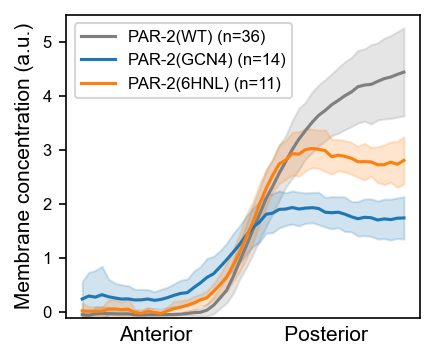

In [6]:
df = pd.read_csv("../../../data/par2_nebd_embryos.csv")
df = df[df.RNAi == "wt"]
df_quantification = pd.read_csv("../../../data/par2_nebd_quantification.csv")


def plot_profile_ant_post(line, ax, c, label):
    embryoIDs = df[df.Line == line].EmbryoID.to_list()
    df_quant_filtered = df_quantification[df_quantification.EmbryoID.isin(embryoIDs)]
    mems = df_quant_filtered.groupby("EmbryoID").apply(
        lambda x: interp_1d_array(x["Membrane signal"].to_numpy(), 100)
    )
    mems_ = np.array([fold(x) / 10000 for x in mems])
    mems_mean = np.mean(mems_, axis=0)
    mems_std = np.std(mems_, axis=0)
    ax.plot(mems_mean, c=c, label=label + " (n=%s)" % len(mems))
    ax.fill_between(
        np.arange(50), mems_mean - mems_std, mems_mean + mems_std, color=c, alpha=0.2
    )


fig, ax = plt.subplots()
plot_profile_ant_post("lp637", ax, "tab:gray", "PAR-2(WT)")
plot_profile_ant_post("nwg376", ax, "tab:blue", "PAR-2(GCN4)")
plot_profile_ant_post("nwg481", ax, "tab:orange", "PAR-2(6HNL)")
ax.set_ylim(bottom=0)
ax.set_xlabel("Anterior                Posterior")
ax.set_ylabel("Membrane concentration (a.u.)")
ax.set_xticks([])
ax.set_ylim(-0.1, 5.5)
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.legend(fontsize=8, loc="upper left")
fig.set_size_inches(3, 2.5)
fig.tight_layout()
fig.savefig("Figs/conc_profile_wt_vs_6hnl.png", dpi=600, transparent=True)
fig.savefig("Figs/conc_profile_wt_vs_6hnl.pdf", transparent=True)